In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE  # For data balancing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [2]:
# Load dataset
data = pd.read_excel('Heart_Disease.xlsx')

In [3]:
# Show the first few rows
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,White,Yes,Yes,Very good,5,Yes,No,Yes
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,White,No,Yes,Very good,7,No,No,No
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,White,Yes,Yes,Fair,8,Yes,No,No
3,No,24.21,No,No,No,0,0,No,Female,75-79,White,No,No,Good,6,No,No,Yes
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,White,No,Yes,Very good,8,No,No,No


In [4]:
# Check for duplicates
print(f'Duplicates detected: {data.duplicated().sum()}')

Duplicates detected: 18078


In [5]:
# Remove duplicates
data.drop_duplicates(inplace=True)

In [6]:
# Check basic statistics
data.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,301717.000000,301717.000000,301717.000000,301717.000000
mean,28.441970,3.572298,4.121475,7.084559
std,6.468134,8.140656,8.128288,1.467122
min,12.020000,0.000000,0.000000,1.000000
25%,24.030000,0.000000,0.000000,6.000000
50%,27.410000,0.000000,0.000000,7.000000
75%,31.650000,2.000000,4.000000,8.000000
max,94.850000,30.000000,30.000000,24.000000


In [7]:
# Check data types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301717 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      301717 non-null  object 
 1   BMI               301717 non-null  float64
 2   Smoking           301717 non-null  object 
 3   AlcoholDrinking   301717 non-null  object 
 4   Stroke            301717 non-null  object 
 5   PhysicalHealth    301717 non-null  int64  
 6   MentalHealth      301717 non-null  int64  
 7   DiffWalking       301717 non-null  object 
 8   Sex               301717 non-null  object 
 9   AgeCategory       301717 non-null  object 
 10  Race              301717 non-null  object 
 11  Diabetic          301717 non-null  object 
 12  PhysicalActivity  301717 non-null  object 
 13  GenHealth         301717 non-null  object 
 14  SleepTime         301717 non-null  int64  
 15  Asthma            301717 non-null  object 
 16  KidneyDisease     301717 

In [8]:
# Check missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64


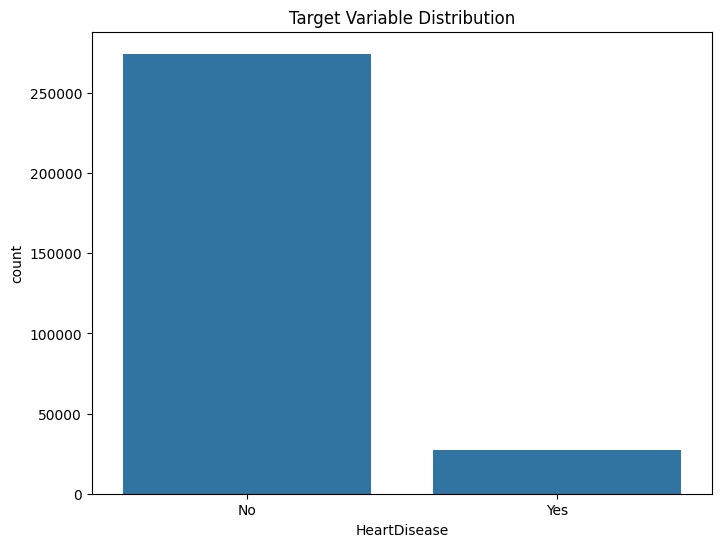

In [9]:
# Visualize the target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='HeartDisease', data=data)
plt.title("Target Variable Distribution")
plt.show()

In [10]:
# Convert categorical data to numerical data
labelencoder = LabelEncoder()
for col in ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'HeartDisease', 'Sex', 'Diabetic', 
            'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'GenHealth', 'Race']:
    data[col] = labelencoder.fit_transform(data[col])

In [11]:
# Handle AgeCategory (convert ranges to numeric values)
def convert_age_to_numeric(age_range):
    if '80 or older' in age_range:
        return 80
    else:
        start, end = map(int, age_range.split('-'))
        return (start + end) / 2

In [12]:
# Apply conversion to the 'AgeCategory' column
data['AgeCategory'] = data['AgeCategory'].apply(convert_age_to_numeric).astype(int)

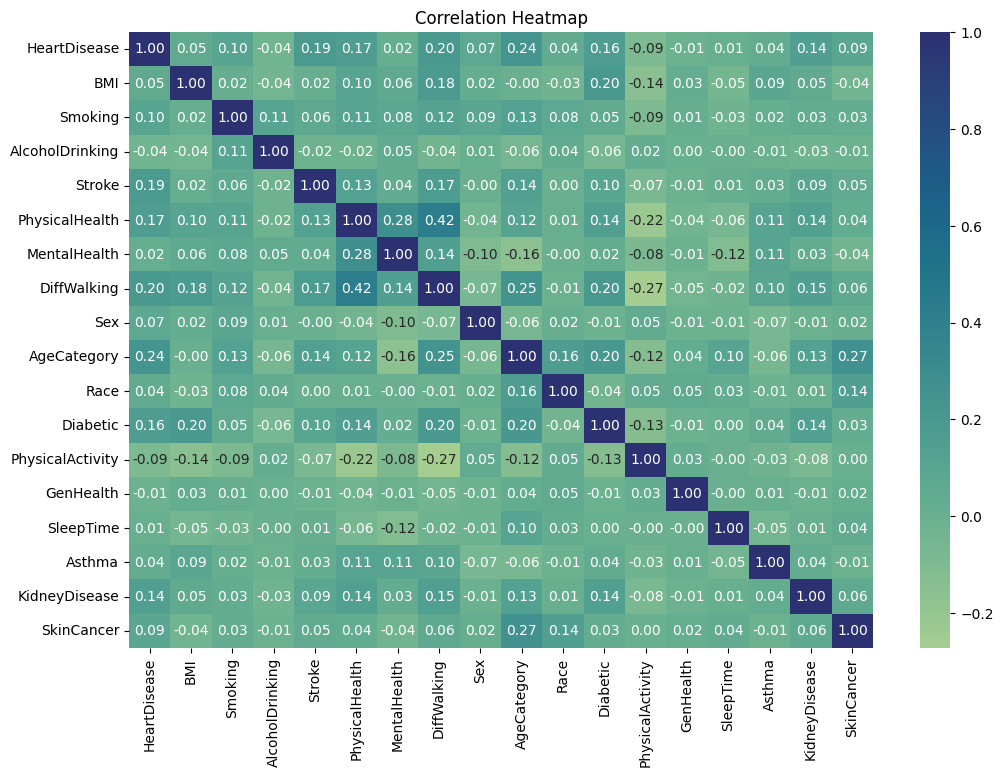

In [13]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [14]:
# Calculate Q1 and Q3 (the first and third quartiles)
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Set bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = ((data < lower_bound) | (data > upper_bound)).sum(axis=0)
print("Outliers detected per feature:\n", outliers)

Outliers detected per feature:
 HeartDisease        27261
BMI                  8905
Smoking                 0
AlcoholDrinking     21581
Stroke              12064
PhysicalHealth      47136
MentalHealth        39713
DiffWalking         44355
Sex                     0
AgeCategory             0
Race                73993
Diabetic            49921
PhysicalActivity    71305
GenHealth               0
SleepTime            4542
Asthma              42651
KidneyDisease       11776
SkinCancer          29292
dtype: int64


In [15]:
# Separate features and target variable
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

In [16]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

Model Training and Evaluation

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

ModuleNotFoundError: No module named 'tensorflow.python'

In [ ]:
# Create the model
model = Sequential()

# input layer
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))

# hidden layers
model.add(Dense(32, activation='relu'))

# output layer
model.add(Dense(1, activation='sigmoid'))  # Sigmoide for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train_resampled, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

# Plot the training history
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

# Accuracy
print("Classification Report:")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

ModuleNotFoundError: No module named 'tensorflow'